## 1) Problem statement.

**Data**: Sensor Data

**Problem statement :**

* The system in focus is the Air Pressure system (APS) which generates pressurized air that are utilized in various functions in a truck, such as braking and gear changes. The datasets positive class corresponds to component failures for a specific component of the APS system. The negative class corresponds to trucks with failures for components not related to the APS system.

* The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false predictions.

                                |**True class ** | *Positive* | *Negative* | 
                               
                             **|Predicted class|**
                                | *Positive*      |   -      | cost_1    |    
                                | *Negative*      | cost_2   |    -      |    
 
Cost 1 = 10 and Cost 2 = 500

* The total cost of a prediction model the sum of Cost_1 multiplied by the number of Instances with type 1 failure and Cost_2 with the number of instances with type 2 failure, resulting in a Total_cost. In this case Cost_1 refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while Cost_2 refer to the cost of missing a faulty truck, which may cause a breakdown.

** **Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.**

* From the above problem statement we could observe that, we have to reduce false positives and false negatives. More importantly we have to reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives.

## Challenges and other objectives
* Need to Handle many Null values in almost all columns
* No low-latency requirement.
* Interpretability is not important.
* misclassification leads the unecessary repair costs.


## ** Import all necessary Libraries **

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,classification_report,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from xgboost import XGBClassifier

%matplotlib inline



## (Read Data)

In [8]:
df=pd.read_csv('aps_failure_training_set1.csv')

In [9]:
df.head(2)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0,182,na,0,0,0,0,0,...,129862,26872,34044,22472,34362,0,0,0,0,0
1,pos,453236,na,2926,na,0,0,0,0,222,...,7908038,3026002,5025350,2025766,1160638,533834,493800,6914,0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36188 entries, 0 to 36187
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 47.2+ MB


### 170 columns are of object type

In [14]:
df.isnull().sum()

class     0
aa_000    0
ab_000    0
ac_000    0
ad_000    0
         ..
ee_007    0
ee_008    0
ee_009    0
ef_000    0
eg_000    0
Length: 171, dtype: int64

In [15]:
df.shape

(36188, 171)

In [16]:
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col],errors='coerce',).replace('na',np.nan).astype(float)

In [17]:
df['class'].value_counts()

neg    35188
pos     1000
Name: class, dtype: int64

### This shows that output data is totally imbalanced, neg output is more dominating

In [18]:
### Define the numerical and categorical features
numerical_features= [feature for feature in df.columns if df[feature].dtype !='O']
categorical_feature= [feature for feature in df.columns if df[feature].dtype =='O']

## Print features
print(f"Numerical features are {numerical_features}")
print(f"Categorical features are {categorical_feature}")

Numerical features are ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000', 'cl_000'

### Find Missing values

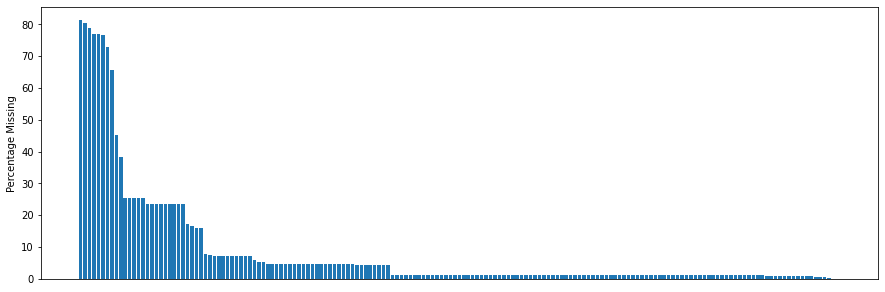

In [19]:
# Plotting missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0,ascending=False)
ax.bar(missing.index,missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage Missing")
plt.show()

Dropping columns which has more has more than 70% of missing values

In [20]:
dropcolumns=missing[missing[0]>60]
dropcolumns

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
ab_000,77.086327
cr_000,77.086327
bo_000,76.533658
bn_000,72.761689
bm_000,65.518957


In [21]:
df.drop(list(dropcolumns.index),axis=1,inplace=True)

In [22]:
df.shape

(36188, 163)

check the total % of missing values with full data set

In [21]:
missing_value_count=df.isnull().sum()
total_cells=np.product(df.shape)
total_missing=missing_value_count.sum()

print(f"Total Cells are : {total_cells}")
print(" percentage of total missing values in data ",total_missing/total_cells*100)

Total Cells are : 6188148
 percentage of total missing values in data  8.333058614629127


Total missing percentage is 5%

## Visualizing of Unique values in Target vriable

positive : 1000, Negative: 35188


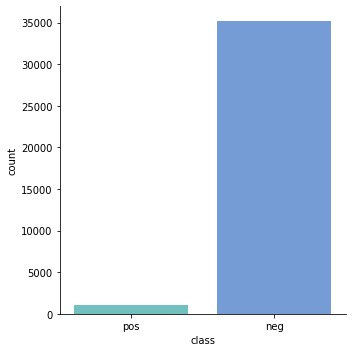

In [22]:
pos = df[df['class']=='pos'].shape[0]
neg = df[df['class']=='neg'].shape[0]

print("positive : "+str(pos) + ", Negative: "+str(neg))
sns.catplot(data = df, x = "class", kind = "count", palette = "winter_r", alpha = .6)
plt.show()

### Report 
* The target classes are highly imbalanced
* Class imbalance is a scenario that arises when we have unequel distribution of class in a dataset i.e the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class)
* If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model.
* Hence we should handle impbalance data with certain methods.

### How to handle imbalance data ?

* Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. 
    There are broadly two types of methods for this 
        1. Undersampling
        2. Oversampling
   In Most Cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances form data that may be carrying some important information
   
* **SMOTE : Synthetic Minority Oversampling Technique**
* SMOTE is an oversampling technique where the synthetic samples are generated for the minority class
* Hybridization techniques involve combining both undersampling and oversampling techniques.This is done to optimize the performance of classifier models for the samples created as part of these techniques.
* It only duplicates the data and wont add any new information. Hence we Look at some different techniques.

## Create Function for model training and evaluation


In [23]:
def evaluate_clf(true, predicted):
    '''
    This Function takes in true values and predicted values
    Returns: Accuracy, F1- Score, Precision, Recall, Roc-Auc Score
    '''
    acc = accuracy_score(true,predicted)
    f1 = f1_score(true,predicted)
    precision = precision_score(true,predicted)
    recall = recall_score(true,predicted)
    roc_auc = roc_auc_score(true, predicted)
    return acc,f1,precision,recall, roc_auc

In [24]:
# Create cost of the model as per data description

def total_cost(y_true, y_pred):
    '''
    This function takes y_true, y_predicted and predict Total cost due to misclassification
    
    '''
    tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost
    
    

In [25]:
# Create a functiuon which can evaluate all the models and return the report

def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluate the metrics
    
    Returns: Dataframe which contains report of all models metrics with cost
    
    '''
    # Seperate the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    cost_list = []
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        
        # Model Training
        model.fit(X_train, y_train)       
        
        # Making Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)    
        
        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision, \
        model_train_recall, model_train_rocauc_score = evaluate_clf(y_train, y_train_pred)
        train_cost = total_cost(y_train,y_train_pred)
        
        # Test set performance
        model_test_accuracy, model_test_f1, model_test_precision, \
        model_test_recall, model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test,y_test_pred)
        
        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])
        
        print('Model performance for Training set')
        print("--Accuracy: {:.4f}".format(model_train_accuracy))
        print("--F1 Score: {:.4f}".format(model_train_f1))
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')
        
        print('-----------------------------------------------')
        
        print('Model performance for Test Set')
        print("--Accuracy: {:.4f}".format(model_test_accuracy))
        print("--F1 Score: {:.4f}".format(model_test_f1))
        print("--Precision: {:.4f}".format(model_test_precision))
        print("--Recall: {:.4f}".format(model_test_recall))
        print("--Roc Auc Score: {:.4f}".format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report = pd.DataFrame(list(zip(models_list,cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
    
    return report

### Plot Distribution of all Independent Numerical Variables


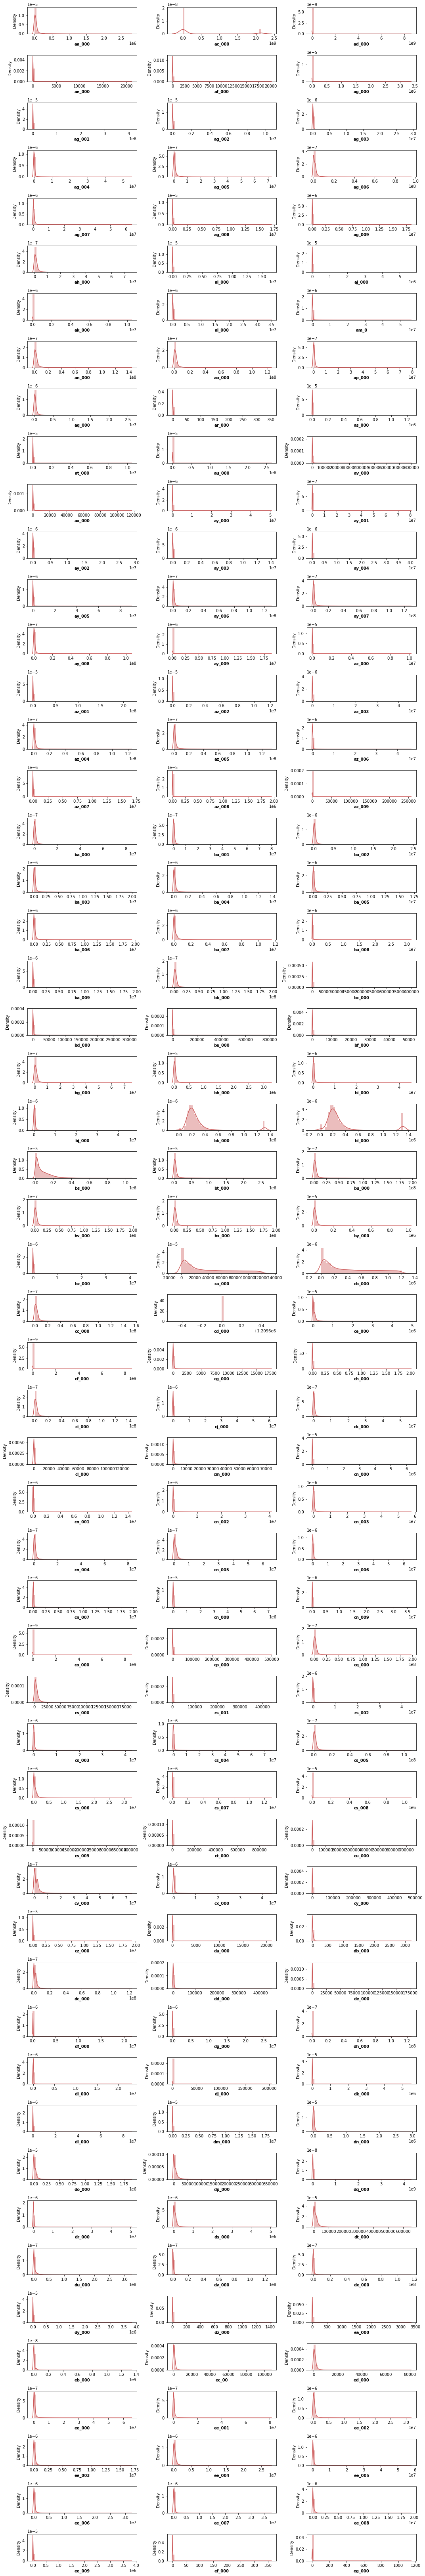

In [28]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize = (15,100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col],color='indianred')
    plt.xlabel(col,weight='bold')
    plt.tight_layout()

### Report
* As per the above plot most of the features are not normally distributed.
* Transformation of data is not of prime importance since it is a classification problem.
* Interpreting each and every column is not necessary as this is sensor data.


### Evaluate Model on Different Experiments


In [29]:
# Splitting X and y for all experiments
X = df.drop('class',axis=1)
y = df['class']

* **Manually Encoding the Target Variable**


In [30]:
y = y.replace({'pos':1,'neg':0})

**Why Robust scaler and not Standard Scaler?**

* Since most of the independent variables are not normally distributed so we cant use Standardscaler.


**Why Robust Scaler not MinMax**

* Because Most of the features has outliers. SO Minmax will scale data according to Max values which is outlier.
* This Scaler removes the median and scales the data according to the quantile range ( default to IQR: Interquartile Range ). The IQR is the range between the 1st quartile and 3rd quantile.

In [31]:
# Fit with robust scaler for KNN best K-Selection experiment
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

#### Why KNN Imputer?
* KNNImputer by scikit-learn is a widely used method to impute missing values. It is widely being observed as a replacement for traditional imputation techniques.
* KNNImputer helps to impute missing values present in the observations by finding the nearest neighbors with the Euclidean distance matrix.
* Here we Iterates through different K values and get accuracy and choose best K values.

#### Finding the optimal n_neighbour value for KNN imputer


In [32]:
from statistics import mean

In [33]:
results = []
# Define imputer

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))),('m',LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print('n_neighbors = %s || accuracy(%.4f)' % (s, mean(scores)))

n_neighbors = 1 || accuracy(0.7077)
n_neighbors = 3 || accuracy(0.6961)
n_neighbors = 5 || accuracy(0.6978)
n_neighbors = 7 || accuracy(0.6391)
n_neighbors = 9 || accuracy(0.6554)


**we can observe n_neighbors = 7 is able to produce highest accuracy**


In [34]:
# Fit the KNN imputer with selected K-value
knn_pipeline = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=7)),
                              ('RobustScaler', RobustScaler())])

In [35]:
X_knn = knn_pipeline.fit_transform(X)

### Handling Imbalance Data

**SMOTE+TOMEK** is one of such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.

* This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class

* To add new data of minority class

1. Choose random data from the minority class.
2. Calculate the distance between the random data and its k nearest neighbors.
3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
4. Repeat step number 2–3 until the desired proportion of minority class is met.

* To remove the tomek links of the majority class
1. Choose random data from the majority class.
2. If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.

* This is method instead of adding duplicate data it synthesises the new data based on the already avalialble classes. Hence we choose this as our imputer method for this problem.

In [36]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy='minority',n_jobs=-1)
# Fit the model to generate the data.
X_res, Y_res = smt.fit_resample(X_knn,y)

In [37]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

### Fit KNN imputed data for models in dictionary


In [38]:
### Fit KNN imputed data for models in dictionary
report_knn = evaluate_models(X_res, Y_res, models)

Random Forest
Model performance for Training set
--Accuracy: 1.0000
--F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
-----------------------------------------------
Model performance for Test Set
--Accuracy: 0.9915
--F1 Score: 0.9915
--Precision: 0.9861
--Recall: 0.9970
--Roc Auc Score: 0.9915
- COST: 11490.


Decision Tree
Model performance for Training set
--Accuracy: 1.0000
--F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
-----------------------------------------------
Model performance for Test Set
--Accuracy: 0.9865
--F1 Score: 0.9866
--Precision: 0.9822
--Recall: 0.9910
--Roc Auc Score: 0.9865
- COST: 32760.


Gradient Boosting
Model performance for Training set
--Accuracy: 0.9836
--F1 Score: 0.9837
- Precision: 0.9807
- Recall: 0.9867
- Roc Auc Score: 0.9836
- COST: 192450.
-----------------------------------------------
Model performance for Test Set
--Accuracy: 0.9802
--F1 Score: 0.9803
--Preci

## Report for Simple Imputer with Constant strategy


In [40]:
report_knn


,Model Name,Cost
5,XGBClassifier,3610
0,Random Forest,11490
1,Decision Tree,32760
4,K-Neighbors Classifier,36820
2,Gradient Boosting,48840
6,AdaBoost Classifier,96490
3,Logistic Regression,223410


**Insights**

* For the Experiment 4: Simple imputer with constant strategy has XGBoost classifier as the best Model
* Proceeding with further experiments

## Experiment: 5 = Simple Imputer with Strategy Mean
* Another strategy which can be used is replacing missing values with mean
* Here we replace the missing values with the mean of the column


In [41]:
# Create a pipeline with Simple imputer with strategy mean
mean_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('RobustScaler', RobustScaler())
])

In [42]:
X_mean = mean_pipeline.fit_transform(X)

In [43]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority' , n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mean, y)


In [44]:
report_mean = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
--Accuracy: 1.0000
--F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
-----------------------------------------------
Model performance for Test Set
--Accuracy: 0.9940
--F1 Score: 0.9940
--Precision: 0.9896
--Recall: 0.9984
--Roc Auc Score: 0.9939
- COST: 6240.


Decision Tree
Model performance for Training set
--Accuracy: 1.0000
--F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
-----------------------------------------------
Model performance for Test Set
--Accuracy: 0.9885
--F1 Score: 0.9886
--Precision: 0.9861
--Recall: 0.9911
--Roc Auc Score: 0.9885
- COST: 32490.


Gradient Boosting
Model performance for Training set
--Accuracy: 0.9853
--F1 Score: 0.9853
- Precision: 0.9820
- Recall: 0.9887
- Roc Auc Score: 0.9853
- COST: 164090.
-----------------------------------------------
Model performance for Test Set
--Accuracy: 0.9853
--F1 Score: 0.9855
--Precis

In [45]:
report_mean

,Model Name,Cost
5,XGBClassifier,4800
0,Random Forest,6240
4,K-Neighbors Classifier,21140
1,Decision Tree,32490
2,Gradient Boosting,41260
6,AdaBoost Classifier,81440
3,Logistic Regression,170330


## Experiment: 6 = Principle component analysis with imputing median
* Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables!
* As the dataset has 164 columns we can try PCA and check our metrics Cost

In [46]:
from sklearn.decomposition import PCA

In [47]:
pca_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [48]:
X_pca = pca_pipeline.fit_transform(X)

In [49]:
#Applying PCA
from sklearn.decomposition import PCA
var_ratio={}
for n in range(2,150):
    pc=PCA(n_components=n)
    df_pca=pc.fit(X_pca)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

<AxesSubplot:>

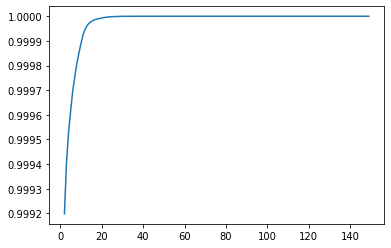

In [50]:
# plotting variance ratio
pd.Series(var_ratio).plot()

**Kneed algorithm to find the elbow point**


In [51]:
! pip install kneed


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


<Figure size 360x360 with 0 Axes>

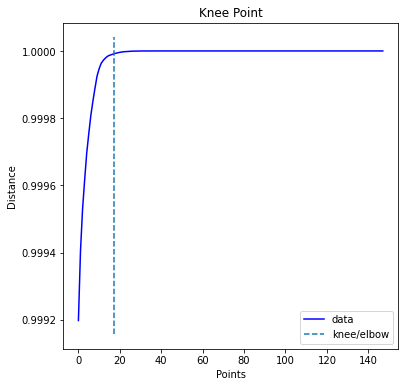

Knee Locator k = 19


In [52]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)

In [53]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=18,random_state=42).fit(X_res)

reduced=pca_final.fit_transform(X_pca)

In [54]:
# Training all models
report_pca = evaluate_models(X_res,y_res, models)

Random Forest
Model performance for Training set
--Accuracy: 1.0000
--F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
-----------------------------------------------
Model performance for Test Set
--Accuracy: 0.9946
--F1 Score: 0.9946
--Precision: 0.9910
--Recall: 0.9983
--Roc Auc Score: 0.9946
- COST: 6640.


Decision Tree
Model performance for Training set
--Accuracy: 1.0000
--F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
-----------------------------------------------
Model performance for Test Set
--Accuracy: 0.9883
--F1 Score: 0.9884
--Precision: 0.9858
--Recall: 0.9909
--Roc Auc Score: 0.9882
- COST: 33010.


Gradient Boosting
Model performance for Training set
--Accuracy: 0.9853
--F1 Score: 0.9853
- Precision: 0.9820
- Recall: 0.9887
- Roc Auc Score: 0.9853
- COST: 164090.
-----------------------------------------------
Model performance for Test Set
--Accuracy: 0.9854
--F1 Score: 0.9855
--Precis

In [55]:
report_pca

,Model Name,Cost
5,XGBClassifier,4800
0,Random Forest,6640
4,K-Neighbors Classifier,21140
1,Decision Tree,33010
2,Gradient Boosting,41250
6,AdaBoost Classifier,81440
3,Logistic Regression,170330


In [56]:
! pip install prettytable


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Model","Imputation_method","Total_cost"]
pt.add_row(["XGBClassifier","Simple Imputer-Constant","3460"])
pt.add_row(["XGBClassifier","Knn-Imputer","4660"])
pt.add_row(["XGBClassifier","Simple Imputer-Mean","5950"])
pt.add_row(["CatBoostClassifier","Median","6120"])
pt.add_row(["XGBClassifier","Mice","7050"])
pt.add_row(["Random Forest","PCA","53120"])
print(pt)

+--------------------+-------------------------+------------+
|       Model        |    Imputation_method    | Total_cost |
+--------------------+-------------------------+------------+
|   XGBClassifier    | Simple Imputer-Constant |    3460    |
|   XGBClassifier    |       Knn-Imputer       |    4660    |
|   XGBClassifier    |   Simple Imputer-Mean   |    5950    |
| CatBoostClassifier |          Median         |    6120    |
|   XGBClassifier    |           Mice          |    7050    |
|   Random Forest    |           PCA           |   53120    |
+--------------------+-------------------------+------------+
